## Assignment - 2 Neural Chef Assistant

## Student - ID 32304692

In [2]:
# importing libraries
import torch
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import tensorflow as tf
from typing import List
from tensorflow.python.eager.context import PhysicalDevice
import numpy as np

In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# checking is GPU is available
torch.cuda.is_available()

True

In [5]:
# setting the growth GPU memory occupying and print devices
try:
    devices: List[PhysicalDevice] = tf.config.list_physical_devices('GPU')
    for device in devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("Use devices:", list(map(lambda d: d.name, devices)))
except IndexError:
    print("Use CPU")

Use devices: ['/physical_device:GPU:0']


In [6]:
torch.cuda.device_count()

1

DATA PREPROCESSING

In [8]:
import os
import re
import string

# Specify the directory you want to start from
rootDirTrain = '/content/drive/MyDrive/Cooking_Dataset/train'
rootDirDev = '/content/drive/MyDrive/Cooking_Dataset/dev'
rootDirTest = '/content/drive/MyDrive/Cooking_Dataset/test'

def make_list(path):
  # Lists to hold all ingredients and recipes
  ingredients = []
  recipes = []

  for dirName, subdirList, fileList in os.walk(path):
    for fname in fileList:
      if fname.endswith('.txt') or fname.endswith('.mmf') or fname.endswith('.TXT') or fname.endswith('.MMF'):
        with open(os.path.join(dirName, fname), 'r') as f:
          content = f.read()

          # Match ingredients and recipes
          matches = re.findall(r"ingredients:(.*?)\n(.*?)END RECIPE", content, re.DOTALL)
          if matches:
            for match in matches:
              # Clean and normalize ingredients
              ingredients_text = match[0]
              ingredients_text = ingredients_text.lower()  # Convert to lowercase
              ingredients_text = ingredients_text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
              ingredients_text = ingredients_text.strip()  # Remove leading/trailing spaces
              ingredients_text = re.sub(r'\s+', ' ', ingredients_text)  # Remove extra whitespaces
              ingredients.append(ingredients_text)

              # Clean and normalize recipes
              recipe_text = match[1]
              recipe_text = recipe_text.lower()  # Convert to lowercase
              recipe_text = recipe_text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
              recipe_text = recipe_text.strip()  # Remove leading/trailing spaces
              recipe_text = re.sub(r'\s+', ' ', recipe_text)  # Remove extra whitespaces
              recipes.append(recipe_text)
  return ingredients, recipes


To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count

In [9]:
SOS_token = 0
EOS_token = 1
UNK_token = 2  # Unknown words

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"UNK": UNK_token}  # Unknown words
        self.word2count = {"UNK": 0}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Count SOS, EOS, UNK

    def addSentence(self, sentence):
        words = sentence.split()  # Split sentence into words
        for word in words:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

All files are in Unicode, to simplify, we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [10]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

we’ll trim the data set to only relatively short and simple sentences. Here, the maximum length is 150 words (that includes ending punctuation) and the filter considers sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [11]:
import random
MAX_LENGTH = 150

def filterPair(pair):
    return len(pair[0].split(" ")) <= MAX_LENGTH and len(pair[1].split(" ")) <= MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(ingredients, recipes, train_percent=0.7):
    ingredients = [normalizeString(ingr) for ingr in ingredients]
    recipes = [normalizeString(rec) for rec in recipes]
    pairs = list(zip(ingredients, recipes))

    print("Original:", len(pairs))
    pairs = filterPairs(pairs)
    print("Filtered:", len(pairs))

    # Randomly sample a percentage of data for training
    random.shuffle(pairs)
    train_size = int(len(pairs) * train_percent)
    train_pairs = pairs[:train_size]
    print("after sampling ", len(train_pairs))
    input_lang = Lang('ingredients')
    output_lang = Lang('recipes')
    for pair in train_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, train_pairs




Calling method to generate data

In [12]:
ingredientsTrain, recipesTrain = make_list(rootDirTrain)
ingredientsDev, recipesDev  = make_list(rootDirDev)
ingredientsTest, recipesTest  = make_list(rootDirTest)

Displaying the dataset count before and after filtering

In [13]:
print("Train data--------------")
input_lang_train, output_lang_train, pairs_train = prepareData(ingredientsTrain, recipesTrain, .6)
print("Dev data----------------")
input_lang_dev, output_lang_dev, pairs_dev = prepareData(ingredientsDev, recipesDev, .1)
print("Test Data-------------")
input_lang_test, output_lang_test, pairs_test = prepareData(ingredientsTest, recipesTest, .1)

Train data--------------
Original: 143907
Filtered: 123758
after sampling  74254
Counted words:
ingredients 20979
recipes 33924
Dev data----------------
Original: 1000
Filtered: 868
after sampling  86
Counted words:
ingredients 648
recipes 1203
Test Data-------------
Original: 1000
Filtered: 870
after sampling  87
Counted words:
ingredients 658
recipes 1144


In [14]:
pairs_train[0]

('3 lb chuck short ribs 1 12 c hot water 34 c unbleached allpurpose flour 8 ea heaping t dark brown sugar 2 ts seasoned salt 13 c catsup 1 ts pepper 14 c red wine vinegar 12 c cooking oil 2 ea cloves garlic minced 2 c sliced onion 2 ea large bay leaves',
 'trim excess fat from short ribs combine flour seasoned salt and pepper dredge shrot ribs brown ribs in oil on all sides in dutch oven remove meat from pan add onions and cook until golden brown place ribs on top of onions combine water brown sugar catsup vinegar garlic and bay leaves pour over ribs cover and bake in moderate oven lrb 350 degrees f rrb 212 hours remove bay leaves before serving')

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Preparing Training data
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ') if word.strip() != '']


def tensorFromSentence(lang, sentence):
    
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(input_lang, output_lang, pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [18]:
# Set the hyperparameters
hidden_size = 256
teacher_forcing_ratio = 1
dropout_rate = 0.1
max_length = 150
learning_rate = 0.01
batch_size = 32

In [19]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
    
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### BASELINE MODEL 1 Seq2Seq without Attention

Encoder

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        return output, hidden, cell

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

Decoder

In [21]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout=dropout_rate)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output = self.softmax(self.out(output[0]))
        return output, hidden, cell

    def init_Hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

Training the model

In [22]:
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden, encoder_cell = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [23]:
def trainIters(encoder, decoder, n_iters, input_lang, output_lang, train_pairs, dev_pairs, print_every=1000, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(train_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    dev_loss_list = []
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            
            
            # Calculate loss on dev set
            dev_loss = 0
            for dev_pair in dev_pairs:
                input_tensor = tensorFromSentence(input_lang, dev_pair[0])
                target_tensor = tensorFromSentence(output_lang, dev_pair[1])
                loss = evaluate_dev_1(input_tensor, target_tensor, encoder, decoder, criterion)
                
                dev_loss += loss
            dev_loss_avg = dev_loss / len(dev_pairs)
            
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            print('Dev loss: %.4f' % dev_loss_avg)

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            dev_loss = 0
            for dev_pair in dev_pairs:
                input_tensor = tensorFromSentence(input_lang, dev_pair[0])
                target_tensor = tensorFromSentence(output_lang, dev_pair[1])
                loss = evaluate_dev_1(input_tensor, target_tensor, encoder, decoder, criterion)
                
                dev_loss += loss
            dev_loss_avg = dev_loss / len(dev_pairs)
            dev_loss_list.append(dev_loss_avg)

    showPlot(plot_losses)
    return plot_losses, dev_loss_list

### Evaluation

Method to calculate the development loss

In [24]:
def evaluate_dev_1(input_tensor, target_tensor, encoder, decoder, criterion):
    with torch.no_grad():
        encoder_hidden, encoder_cell = encoder.init_hidden()
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)
        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.topk(1)
            if topi.squeeze().detach().item() == EOS_token:
                break

            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[di])

        return loss.item() / target_length

Method to get the decoded sentence

In [25]:
def evaluate1(encoder, decoder, input_lang, output_lang, pair, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, pair)
        input_length = input_tensor.size(0)
        encoder_hidden, encoder_cell = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

Randomly generating prediction

In [26]:
def evaluateRandomly(encoder, decoder,input_lang, output_lang, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate1(encoder, decoder,input_lang, output_lang, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### Training and Evaluating

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


11m 49s (- 106m 24s) (4000 10%) 5.2103
Dev loss: 7.9028
23m 34s (- 94m 17s) (8000 20%) 4.8317
Dev loss: 5.4374
35m 12s (- 82m 10s) (12000 30%) 4.7865
Dev loss: 8.6253
46m 46s (- 70m 9s) (16000 40%) 4.7597
Dev loss: 3.0855
58m 18s (- 58m 18s) (20000 50%) 4.7508
Dev loss: 8.6230
70m 0s (- 46m 40s) (24000 60%) 4.7371
Dev loss: 9.0366
81m 36s (- 34m 58s) (28000 70%) 4.7405
Dev loss: 7.9268
93m 24s (- 23m 21s) (32000 80%) 4.7786
Dev loss: 9.0590
105m 13s (- 11m 41s) (36000 90%) 4.7451
Dev loss: 9.1296
117m 1s (- 0m 0s) (40000 100%) 4.8217
Dev loss: 9.3941


<Figure size 640x480 with 0 Axes>

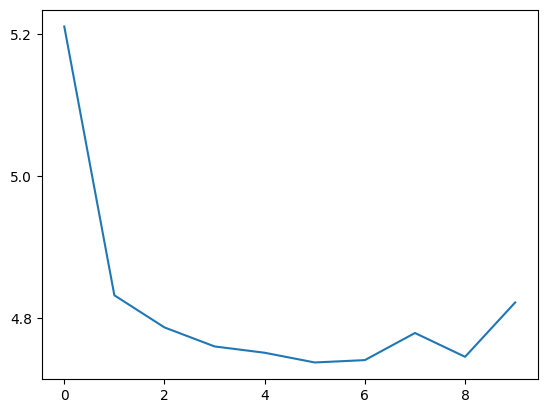

In [27]:
hidden_size = 256
encoder1 = Encoder(input_lang_train.n_words, hidden_size, dropout_rate).to(device)
decoder1 = Decoder(hidden_size, output_lang_train.n_words, dropout_rate).to(device)
model_train_1, model_dev_1 = trainIters(encoder1, decoder1, 40000, input_lang_train, output_lang_train, pairs_train, pairs_dev, print_every=4000, plot_every=4000)


In [28]:
evaluateRandomly(encoder1, decoder1, input_lang_train, output_lang_train, pairs_test, n=5)

> 3 tb butter 4 tb flour 1 c brown sugar 1 egg 1 c milk 1 ts vanilla 1 baked pastry shell whipped cream
= cream butter flour and sugar together beat egg add milk and add to creamed mixture cook in top of double boiler until thickened stirring constantly cool and add vanilla pour into pastry shell and chill spread with the whipped cream before serving
< in a large bowl combine all ingredients and salt in a large bowl combine all ingredients and cook for 5 minutes or until smooth add the remaining ingredients and water to the butter and salt in a large bowl combine all ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the flour and cook for 5 minutes or until smooth add the flour and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until 

### BASELINE MODEL 2 Seq2Seq with Attention

Decoder

In [29]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, cell, attn_weights

    def init_Hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

### Training

In [31]:
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden, encoder_cell = encoder.init_hidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = min(input_tensor.size(0), max_length)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [ ]:
def trainIters_attn(encoder, decoder, n_iters, input_lang, output_lang, pairs, dev_pairs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    dev_loss_list = []
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                          decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            

            # Calculate loss on development set
            dev_loss = 0
            with torch.no_grad():
                for dev_pair in dev_pairs:
                    input_tensor = tensorFromSentence(input_lang, dev_pair[0])
                    target_tensor = tensorFromSentence(output_lang, dev_pair[1])
                    loss = calculate_loss(input_tensor, target_tensor, encoder, decoder, criterion)
                    
                    dev_loss += loss
            dev_loss_avg = dev_loss / len(dev_pairs)
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            print('Dev loss: %.4f' % dev_loss_avg)

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            dev_loss = 0
            with torch.no_grad():
                for dev_pair in dev_pairs:
                    input_tensor = tensorFromSentence(input_lang, dev_pair[0])
                    target_tensor = tensorFromSentence(output_lang, dev_pair[1])
                    loss = calculate_loss(input_tensor, target_tensor, encoder, decoder, criterion)
                    
                    dev_loss += loss
            dev_loss_avg = dev_loss / len(dev_pairs)
            dev_loss_list.append(dev_loss_avg)

    showPlot(plot_losses)
    return plot_losses, dev_loss_list

### Evaluation

Method to get predicted sentences

In [32]:
def evaluate_attn(encoder, decoder, input_lang, output_lang, sentence, max_length=MAX_LENGTH): 
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei],
                                                     encoder_hidden, encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

Method to generate random prediction

In [33]:
def evaluateRandomly_attn(encoder, input_lang, output_lang, pairs, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate_attn(encoder, decoder, input_lang, output_lang, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Method to evaluate development loss

In [34]:
def calculate_loss(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden, encoder_cell = encoder.init_hidden()

    input_length = min(input_tensor.size(0), max_length)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

13m 28s (- 121m 19s) (4000 10%) 7.3617
Dev loss: 7.8039
27m 5s (- 108m 21s) (8000 20%) 7.2738
Dev loss: 7.4468
40m 51s (- 95m 19s) (12000 30%) 7.2673
Dev loss: 7.6602
54m 29s (- 81m 44s) (16000 40%) 7.3270
Dev loss: 7.6258
68m 6s (- 68m 6s) (20000 50%) 7.3904
Dev loss: 7.7000
81m 45s (- 54m 30s) (24000 60%) 7.3567
Dev loss: 8.0845
95m 22s (- 40m 52s) (28000 70%) 7.3472
Dev loss: 8.3787
108m 54s (- 27m 13s) (32000 80%) 7.3595
Dev loss: 7.6587
122m 28s (- 13m 36s) (36000 90%) 7.3193
Dev loss: 7.6921
135m 57s (- 0m 0s) (40000 100%) 7.2818
Dev loss: 8.5454


<Figure size 640x480 with 0 Axes>

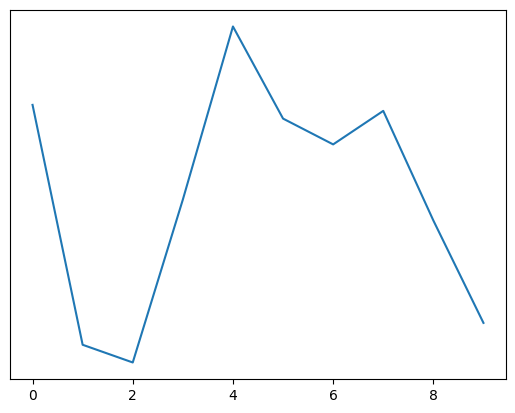

In [35]:
hidden_size = 256
encoder2 = Encoder(input_lang_train.n_words, hidden_size, dropout_rate).to(device)
decoder2 = AttnDecoder(hidden_size, output_lang_train.n_words, dropout_p=0.1).to(device)

model_train_2, model_dev_2 = trainIters_attn(encoder2, decoder2, 40000, input_lang_train, output_lang_train, pairs_train, pairs_dev, print_every=4000, plot_every=4000)

In [36]:
evaluateRandomly_attn(encoder2, input_lang_train, output_lang_train, pairs_test, decoder2, n=5)

> 14 c plus 1 tbs hoisin sauce 3 tb honey 2 tb soy sauce 2 tb dry sherry 2 tb sesame seeds 1 jalapeno chile seeded and minced 1 tb sesame oil 1 tb curry powder 1 tb orange zest finely grated 1 tb fermented black beans
= combine all the ingredients in a medium bowl use with any kind of beefsteak lamb or duck marinate 13 hours or use as a dipping sauce
< fry in 2quart fat from from from from from from fat fat fat from from in tomatoes in tomatoes peel remove peel remove peel remove peel peel peel peel peel peel peel peel peel peel peel peel peel peel with lean lean dill dill dill dill dill surround grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant 

### TOP K Sampling model

Decoder

In [38]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate, top_k=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.top_k = top_k

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout=dropout_rate)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        output = self.out(output[0])

        # Top-k sampling
        probabilities = F.softmax(output, dim=1)
        top_k_probabilities, top_k_indices = probabilities.topk(self.top_k, dim=1)
        choice = torch.multinomial(top_k_probabilities, 1)
        next_word_index = top_k_indices[0, choice]

        return output, next_word_index, hidden, cell

Encoder

In [39]:
# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        return output, hidden, cell

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

### Training

In [40]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_hidden, encoder_cell = encoder.init_hidden()

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_input, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        for di in range(target_length):
            decoder_output, decoder_input, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token or di == max_length - 1: # break if reach EOS_token or max_length
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [43]:
def trainIters(encoder, decoder, n_iters, input_lang, output_lang, train_pairs, dev_pairs, print_every=1000, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(train_pairs))
                      for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()
    dev_loss = []
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            
            # Calculate loss on dev set
            dev_loss_avg = evaluate_all(encoder, decoder, dev_pairs, input_lang, output_lang, criterion)
            
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            print('Dev loss: %.4f' % dev_loss_avg)

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            dev_loss_avg = evaluate_all(encoder, decoder, dev_pairs, input_lang, output_lang, criterion)
            dev_loss.append(dev_loss_avg)

    showPlot(plot_losses)
    return plot_losses, dev_loss

### Evaluation

Method to generate random predictions

In [ ]:
def evaluateRandomly(encoder, input_lang, output_lang, pairs, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate3(encoder, decoder, input_lang, output_lang, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Method to compute development loss

In [ ]:
def evaluate_all(encoder, decoder, dev_pairs, input_lang, output_lang, criterion, max_length=MAX_LENGTH):
    dev_loss = 0
    for dev_pair in dev_pairs:
        input_tensor = tensorFromSentence(input_lang, dev_pair[0])
        target_tensor = tensorFromSentence(output_lang, dev_pair[1])
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_hidden, encoder_cell = encoder.init_hidden()

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        for di in range(target_length):
            decoder_output, decoder_input, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token or di == max_length - 1:
                break

        dev_loss += loss.item() / target_length
    return dev_loss / len(dev_pairs)

Method to get prediction

In [ ]:
def evaluate3(encoder, decoder, input_lang, output_lang, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.init_hidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei].view(1, 1, -1),
                                                     encoder_hidden, encoder_cell)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_input, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

#### Training and Evaluating


13m 8s (- 118m 16s) (4000 10%) 4.9283
Dev loss: 6.5902
26m 31s (- 106m 7s) (8000 20%) 4.1753
Dev loss: 6.8311
39m 55s (- 93m 9s) (12000 30%) 3.9484
Dev loss: 6.8226
53m 13s (- 79m 50s) (16000 40%) 3.8688
Dev loss: 7.0391
66m 45s (- 66m 45s) (20000 50%) 3.8353
Dev loss: 7.1071
79m 56s (- 53m 17s) (24000 60%) 3.8006
Dev loss: 7.2142
93m 7s (- 39m 54s) (28000 70%) 3.7506
Dev loss: 6.4339
106m 26s (- 26m 36s) (32000 80%) 3.6890
Dev loss: 6.8237
119m 50s (- 13m 18s) (36000 90%) 3.7067
Dev loss: 6.9803
133m 1s (- 0m 0s) (40000 100%) 3.6821
Dev loss: 7.4717


<Figure size 640x480 with 0 Axes>

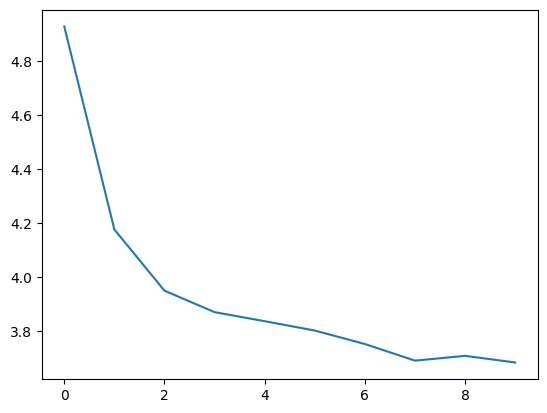

In [44]:
# Set the parameters
hidden_size = 256
dropout_rate = 0.1
learning_rate = 0.001
teacher_forcing_ratio = 1
n_iters = 40000
print_every = 4000
plot_every = 4000

# Create the encoder and decoder models
encoder3 = Encoder(input_lang_train.n_words, hidden_size, dropout_rate).to(device)
decoder3 = Decoder(hidden_size, output_lang_train.n_words, dropout_rate, top_k=5).to(device)

# Train the models
model_train_3, model_dev_3 = trainIters(encoder3, decoder3, n_iters, input_lang_train, output_lang_train, pairs_train, pairs_dev, print_every, plot_every)

In [45]:
evaluateRandomly(encoder3, input_lang_test, output_lang_test, pairs_test, decoder3, n=5)

> 1 c fresh blackberries washed and dried 1 tb sugar 1 lg egg 1 c plain or honey yogurt 3 tb butter or margarine melted 2 12 c variety baking mix eg bisquik 1 ts chopped lemon zest
= preheat oven to 400f sprinkle berries with sugar toss lightly to coat set aside in a large bowl beat egg add yogurt and melted butter or margarine beat until smooth add baking mix stir until just blended fold in berries and lemon zest spoon mixture into greased or sprayed muffin cups 3 inch in diameter and 112 inch deep bake for 2025 minutes or until a toothpick inserted in the centre comes out clean cool for 5 minutes in cups finish cooling on rack
< cubes lemon strips with once pan melt glass done buttermilk all except crumbs kind except strips glass done buttermilk all except crumbs kind except strips glass done buttermilk quarter glass melon to bake gail drippings about 10 min <EOS>

> 14 c plus 1 tbs hoisin sauce 3 tb honey 2 tb soy sauce 2 tb dry sherry 2 tb sesame seeds 1 jalapeno chile seeded and m

### Coverage Mechanism

Decoder

In [46]:
class DecoderWithCoverage(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate, coverage_weight=0.2):
        super(DecoderWithCoverage, self).__init__()
        self.hidden_size = hidden_size
        self.coverage_weight = coverage_weight

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        self.Wc = nn.Linear(1, hidden_size, bias=False)  # Coverage vector weights
        self.Wh = nn.Linear(hidden_size, hidden_size, bias=False)  # Hidden state weights
        self.Ws = nn.Linear(hidden_size, hidden_size, bias=False)  # Decoder state weights
        self.v = nn.Linear(hidden_size, 1, bias=False)  # Context vector weights

    def forward(self, input, hidden, cell, coverage):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        lstm_out, (hidden, cell) = self.lstm(embedded, (hidden, cell))

        e = self.v(torch.tanh(self.Wh(hidden) + self.Ws(lstm_out) + self.Wc(coverage)))
        attn_weights = F.softmax(e, dim=1)
        coverage = coverage + attn_weights  # Update coverage vector

        output = self.softmax(self.out(lstm_out[0]))
        return output, hidden, cell, coverage, attn_weights

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

    def init_coverage(self):
        return torch.zeros(1, 1, 1, device=device)

    def coverage_loss(self, attn_weights, coverage):
        return torch.sum(torch.min(attn_weights, coverage))

    def total_loss(self, output, target, attn_weights, coverage):
        target = target.view(-1)  # Flatten target tensor
        cross_entropy_loss = F.nll_loss(output, target)
        cov_loss = self.coverage_loss(attn_weights, coverage)
        return cross_entropy_loss + self.coverage_weight * cov_loss

### Training

In [47]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden, encoder_cell = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)
    coverage = decoder.init_coverage()

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, coverage, attn_weights = decoder(
                decoder_input, decoder_hidden, decoder_cell, coverage)
            loss += decoder.total_loss(decoder_output, target_tensor[di], attn_weights, coverage)
            decoder_input = target_tensor[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, coverage, attn_weights = decoder(
                decoder_input, decoder_hidden, decoder_cell, coverage)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            
            loss += decoder.total_loss(decoder_output, target_tensor[di], attn_weights, coverage)
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [75]:
def trainIters(encoder, decoder, n_iters, input_lang, output_lang, train_pairs, dev_pairs, print_every=1000, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(train_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    dev_list = []
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            
            
            # Calculate loss on dev set
            dev_loss = 0
            with torch.no_grad():
                for dev_pair in dev_pairs:
                    input_tensor = tensorFromSentence(input_lang, dev_pair[0])
                    target_tensor = tensorFromSentence(output_lang, dev_pair[1])
                    loss = calculate_loss_conv(input_tensor, target_tensor, encoder, decoder, criterion)
                    dev_loss += loss
            dev_loss_avg = dev_loss / len(dev_pairs)
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            print('Dev loss: %.4f' % dev_loss_avg)

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            dev_loss = 0
            with torch.no_grad():
                for dev_pair in dev_pairs:
                    input_tensor = tensorFromSentence(input_lang, dev_pair[0])
                    target_tensor = tensorFromSentence(output_lang, dev_pair[1])
                    loss = calculate_loss_conv(input_tensor, target_tensor, encoder, decoder, criterion)
                    dev_list.append(loss)
                    dev_loss += loss
            dev_loss_avg = dev_loss / len(dev_pairs)
            dev_list.append(dev_loss_avg)

    showPlot(plot_losses)
    return plot_losses, dev_list

### Evaluation

In [76]:
def calculate_loss_conv(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden, encoder_cell = encoder.init_hidden()

    input_length = min(input_tensor.size(0), max_length)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    coverage = decoder.init_coverage()

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_cell, coverage, attn_weights = decoder(
            decoder_input, decoder_hidden, decoder_cell, coverage)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += decoder.total_loss(decoder_output, target_tensor[di], attn_weights, coverage)
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

Method to get prediction

In [50]:
def evaluateconv(encoder, decoder, input_lang, output_lang, pair, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, pair)
        input_length = input_tensor.size(0)
        encoder_hidden, encoder_cell = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        coverage = decoder.init_coverage() # Initialize coverage

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, coverage, attn_weights = decoder(decoder_input, decoder_hidden, decoder_cell, coverage) # Include coverage and attn_weights
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                #print(output_lang.index2word)
                #print(topi.item())
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


In [77]:
def evaluateRandomly(encoder, decoder,input_lang, output_lang, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluateconv(encoder, decoder,input_lang, output_lang, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

13m 57s (- 125m 38s) (4000 10%) 5.1251
Dev loss: 8.0432
28m 8s (- 112m 34s) (8000 20%) 4.3580
Dev loss: 8.3260
42m 15s (- 98m 35s) (12000 30%) 4.1609
Dev loss: 6.1784
56m 16s (- 84m 24s) (16000 40%) 4.0917
Dev loss: 6.3902
70m 11s (- 70m 11s) (20000 50%) 4.0194
Dev loss: 5.0230
84m 18s (- 56m 12s) (24000 60%) 3.9962
Dev loss: 5.9059
98m 27s (- 42m 11s) (28000 70%) 3.9433
Dev loss: 6.6964
112m 29s (- 28m 7s) (32000 80%) 3.9413
Dev loss: 5.5122
126m 17s (- 14m 1s) (36000 90%) 3.8863
Dev loss: 8.5200
140m 8s (- 0m 0s) (40000 100%) 3.9089
Dev loss: 6.0257
140m 8s (- 0m 0s) (40000 100%) 3.9089
Dev loss: 6.0257


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

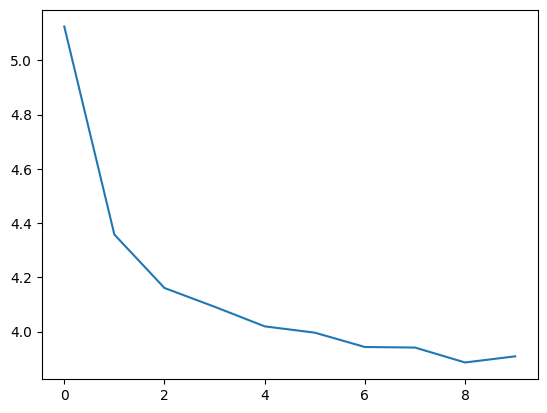

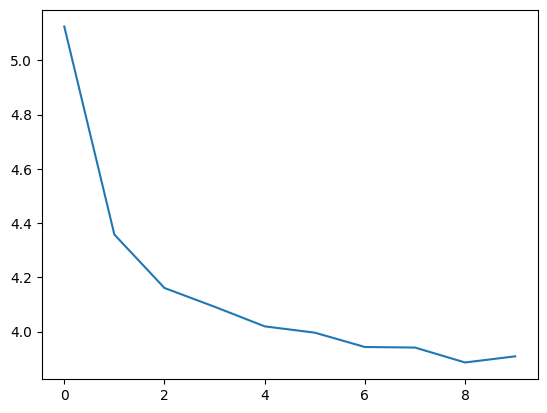

In [52]:
hidden_size = 256
encoder4 = Encoder(input_lang_train.n_words, hidden_size, dropout_rate).to(device)
decoder4 = DecoderWithCoverage(hidden_size, output_lang_train.n_words, dropout_rate).to(device)
model_train_4, model_dev_4 = trainIters(encoder4, decoder4, 40000, input_lang_train, output_lang_train, pairs_train, pairs_dev, print_every=4000, plot_every=4000)


In [58]:
evaluateRandomly(encoder4, decoder4, input_lang_train, output_lang_train, pairs_test, n=5)

> 6 c white or red potatoes 1 tb soft marg 12 c minced fresh mint 1 tb fresh lemon juice
= quarter and slice potatoes in large saucepan boil potatoes in water until tender about 10 min drain in large saute pan melt marg saute mint with lemon juice for 1 min add potatoes and toss to coat reheat serve
< in a large bowl combine all ingredients except the nuts and mix well chill until ready to serve <EOS>

> 12 oz rotelle pasta 9 oz frozen frenchcut green beans 12 lb turkey ham thinly sliced 2 tb corn oil margarine 14 c unbleached flour 2 c nonfat milk 14 c dry white wine 4 oz brie cheese rind removed ut into chunks 2 oz reducedfat monterey jack cheese shredded
= cook pasta according to package directions adding green beans during last 2 minutes of cooking cut turkey ham into thin strips and set aside meanwhile in medium saucepan melt margarine stir in flour and cook 2 minutes stirring constantly gradually add milk bring to a boil whisking until smooth add wine to sauce boil 1 minute whisk

### Quantitative Evaluation

In [59]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score
import pandas as pd
from nltk.translate.bleu_score import SmoothingFunction
import nltk
nltk.download('wordnet')
def avg_given_items(reference, hypothesis):
    count = 0
    for word in reference:
        if word in hypothesis:
            count += 1
    return count / len(reference) if len(reference) != 0 else 0

def avg_extra_items(reference, hypothesis):
    count = 0
    for word in hypothesis:
        if word not in reference:
            count += 1
    return count / len(hypothesis) if len(hypothesis) != 0 else 0






[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def evaluate_metrics(reference, hypothesis):
    # Transform the inputs into word lists
    reference_words = reference
    hypothesis_words = hypothesis

    # Transform lists of words into sentences
    reference_sentence = ' '.join(reference_words)
    hypothesis_sentence = ' '.join(hypothesis_words)

    # Calculate BLEU and METEOR scores
    smoothie = SmoothingFunction().method4
    bleu = sentence_bleu([reference_words], hypothesis_words, smoothing_function=smoothie)
    meteor = single_meteor_score(reference, hypothesis)

    # Calculate Average % given items and Average extra items
    avg_given, avg_extra = avg_given_items(reference_words, hypothesis_words), avg_extra_items(reference_words, hypothesis_words)
    return bleu, meteor, avg_given, avg_extra

In [63]:
def evaluate_and_get_metrics(modelName, encoder, decoder, input_lang, output_lang, pairs):
    total_bleu = 0
    total_meteor = 0
    total_avg_given = 0
    total_avg_extra = 0
    num_pairs = len(pairs)
    results = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        reference = output_sentence.split()  # split the string into a list of words
        if modelName == "Converge Mechanism":
          hypothesis = evaluateconv(encoder, decoder, input_lang, output_lang, input_sentence)  # Pass the entire pair
        elif modelName == "baseline1":
          hypothesis = evaluate1(encoder, decoder, input_lang, output_lang, input_sentence)
        elif modelName == "baseline2":
          hypothesis = evaluate_attn(encoder, decoder, input_lang, output_lang, input_sentence)
        elif modelName == "topK Sampling":
          hypothesis = evaluate3(encoder, decoder, input_lang, output_lang, input_sentence)
        if '<EOS>' in hypothesis:  # Remove EOS token if it is present
            hypothesis.remove('<EOS>')
        
        bleu, meteor, avg_given, avg_extra = evaluate_metrics(reference, hypothesis)
        total_bleu += bleu
        total_meteor += meteor
        total_avg_given += avg_given
        total_avg_extra += avg_extra
    avg_bleu = total_bleu / num_pairs
    avg_meteor = total_meteor / num_pairs
    avg_given = total_avg_given / num_pairs
    avg_extra = total_avg_extra / num_pairs
    results.append([modelName, avg_bleu, avg_meteor, avg_given, avg_extra])
    return results

In [64]:
result = []
results = evaluate_and_get_metrics("baseline1", encoder1, decoder1, input_lang_train, output_lang_train, pairs_test)



#results.append(evaluate_and_get_metrics("baseline1", encoder1, decoder1, input_lang_train, output_lang_train, pairs_test))
results.append(evaluate_and_get_metrics("baseline2",encoder2, decoder2, input_lang_train, output_lang_train, pairs_test))
results.append(evaluate_and_get_metrics("topK Sampling", encoder3, decoder3, input_lang_train, output_lang_train, pairs_test))

results.append(evaluate_and_get_metrics("Converge Mechanism", encoder4, decoder4, input_lang_train, output_lang_train, pairs_test))

flattened_list = [item[0] if isinstance(item[0], list) else item for item in results]


# Convert results to a Pandas DataFrame and display
df = pd.DataFrame(flattened_list, columns=['Model Name','BLEU', 'METEOR', 'Avg. % given items', 'Avg. extra items'])
df

,Model Name,BLEU,METEOR,Avg. % given items,Avg. extra items
0,baseline1,0.013229,0.124881,0.263263,0.557720
1,baseline2,0.003654,0.030913,0.091910,0.923985
2,topK Sampling,0.026032,0.153213,0.303827,0.592057
3,Converge Mechanism,0.018015,0.121907,0.264701,0.646822


### ANALYSIS

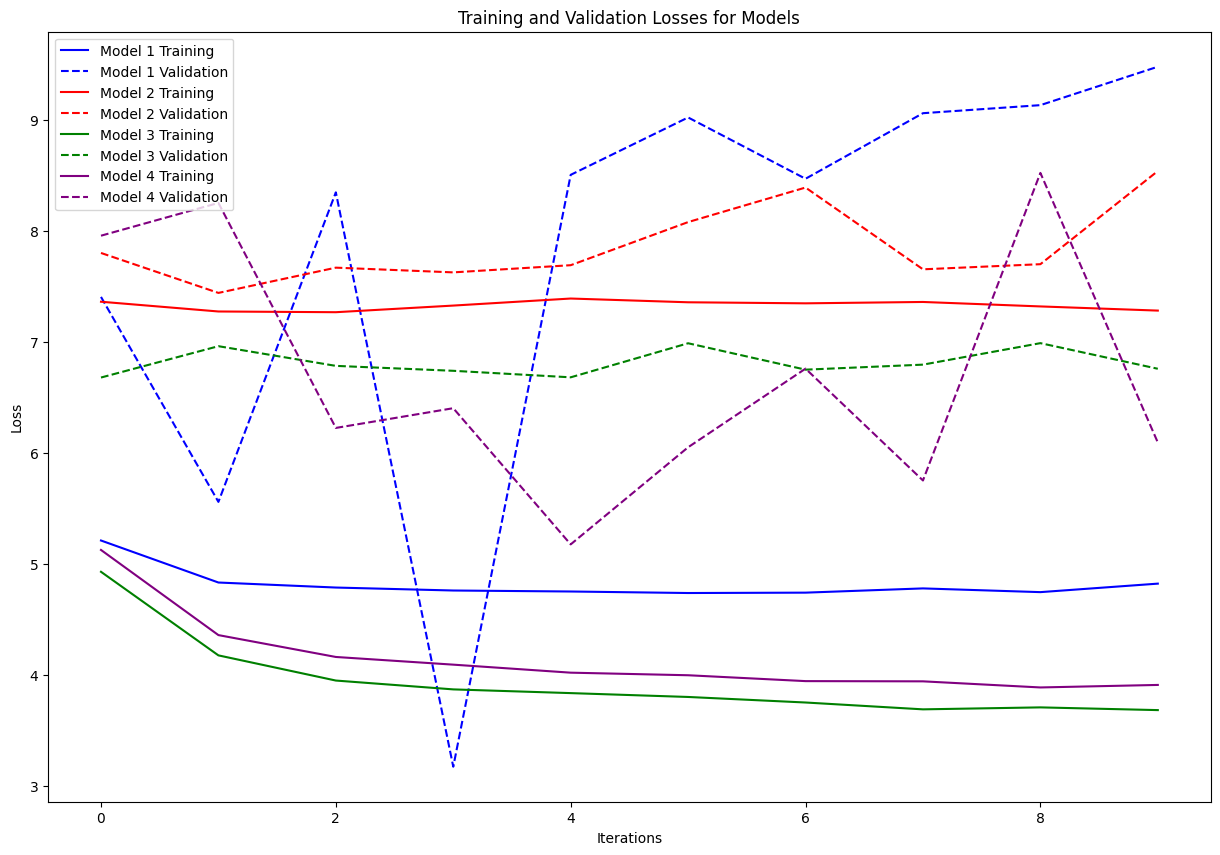

In [84]:
import matplotlib.pyplot as plt

# let's assume you have your losses stored in the following lists:
# replace these with your actual data
training_losses_model1 = model_train_1
validation_losses_model1 = model_dev_1

training_losses_model2 = model_train_2
validation_losses_model2 = model_dev_2

training_losses_model3 = model_train_3
validation_losses_model3 = model_dev_3

training_losses_model4 = model_train_4
validation_losses_model4 = model_dev_4

# create a new figure
plt.figure(figsize=(15,10))

# plot training and validation losses for model1
plt.plot(training_losses_model1, color='blue', linestyle='solid', label='Model 1 Training')
plt.plot(validation_losses_model1, color='blue', linestyle='dashed', label='Model 1 Validation')

# plot training and validation losses for model2
plt.plot(training_losses_model2, color='red', linestyle='solid', label='Model 2 Training')
plt.plot(validation_losses_model2, color='red', linestyle='dashed', label='Model 2 Validation')

# plot training and validation losses for model3
plt.plot(training_losses_model3, color='green', linestyle='solid', label='Model 3 Training')
plt.plot(validation_losses_model3, color='green', linestyle='dashed', label='Model 3 Validation')

# plot training and validation losses for model4
plt.plot(training_losses_model4, color='purple', linestyle='solid', label='Model 4 Training')
plt.plot(validation_losses_model4, color='purple', linestyle='dashed', label='Model 4 Validation')

# add legend, labels and title
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Models')

# show the plot
plt.show()

### DATA STATISTICS

In [85]:
def get_data_stats(data):
    num_samples = len(data)
    vocab_size = len(set(' '.join(data).split()))
    lengths = [len(s.split()) for s in data]
    min_length = min(lengths)
    max_length = max(lengths)
    avg_length = np.mean(lengths)
    return num_samples, vocab_size, min_length, max_length, avg_length

In [88]:
from collections import Counter

import pandas as pd

# Prepare an empty DataFrame
df = pd.DataFrame(columns=['Dataset', 'Data Type', 'Number of Samples', 'Vocabulary Size', 'Min Length', 'Max Length', 'Average Length'])

# Define a helper function to append rows to the DataFrame
def add_row(df, dataset, data_type, data):
    num_samples, vocab_size, min_length, max_length, avg_length = get_data_stats(data)
    row = [dataset, data_type, num_samples, vocab_size, min_length, max_length, avg_length]
    df.loc[len(df)] = row

# Append data statistics to the DataFrame
add_row(df, 'Train', 'Ingredients', ingredientsTrain)
add_row(df, 'Train', 'Recipes', recipesTrain)
add_row(df, 'Dev', 'Ingredients', ingredientsDev)
add_row(df, 'Dev', 'Recipes', recipesDev)
add_row(df, 'Test', 'Ingredients', ingredientsTest)
add_row(df, 'Test', 'Recipes', recipesTest)

# Define a helper function to get more stats
def get_more_data_stats(data):
    unique_count = len(set(data))
    word_list = ' '.join(data).split()
    word_counter = Counter(word_list)
    most_common_word, most_common_word_freq = word_counter.most_common(1)[0]
    least_common_word, least_common_word_freq = word_counter.most_common()[-1]
    median_length = np.median([len(s.split()) for s in data])
    std_dev_length = np.std([len(s.split()) for s in data])
    return unique_count, most_common_word, most_common_word_freq, least_common_word, least_common_word_freq, median_length, std_dev_length

# Extend the columns of DataFrame
df = pd.DataFrame(columns=['Dataset', 'Data Type', 'Number of Samples', 'Vocabulary Size', 'Min Length', 'Max Length', 'Average Length', 'Unique Count', 'Most Common Word', 'Most Common Word Frequency', 'Least Common Word', 'Least Common Word Frequency', 'Median Length', 'Std Dev of Lengths'])

# Redefine the helper function to append rows to the DataFrame
def add_row(df, dataset, data_type, data):
    num_samples, vocab_size, min_length, max_length, avg_length = get_data_stats(data)
    unique_count, most_common_word, most_common_word_freq, least_common_word, least_common_word_freq, median_length, std_dev_length = get_more_data_stats(data)
    row = [dataset, data_type, num_samples, vocab_size, min_length, max_length, avg_length, unique_count, most_common_word, most_common_word_freq, least_common_word, least_common_word_freq, median_length, std_dev_length]
    df.loc[len(df)] = row

# Append data statistics to the DataFrame
add_row(df, 'Train', 'Ingredients', ingredientsTrain)
add_row(df, 'Train', 'Recipes', recipesTrain)
add_row(df, 'Dev', 'Ingredients', ingredientsDev)
add_row(df, 'Dev', 'Recipes', recipesDev)
add_row(df, 'Test', 'Ingredients', ingredientsTest)
add_row(df, 'Test', 'Recipes', recipesTest)

# Print the DataFrame
df

,Dataset,Data Type,Number of Samples,Vocabulary Size,Min Length,Max Length,Average Length,Unique Count,Most Common Word,Most Common Word Frequency,Least Common Word,Least Common Word Frequency,Median Length,Std Dev of Lengths
0,Train,Ingredients,143907,29564,0,417,41.703878,120992,1,468757,letus,1,39.0,20.850720
1,Train,Recipes,143907,52631,0,796,90.258083,91038,and,663339,matm,1,75.0,65.243460
2,Dev,Ingredients,1000,2658,1,167,40.600000,992,1,3084,lemongarlic,1,38.0,21.916158
3,Dev,Recipes,1000,4862,2,550,87.681000,999,and,4536,sweethot,1,74.0,63.453946
4,Test,Ingredients,1000,2488,1,180,39.808000,993,1,3054,ndrained,1,38.0,20.081363
5,Test,Recipes,1000,4688,2,732,89.017000,1000,and,4510,snakes,1,73.0,67.170192


### Qualitative Evaluation

In [89]:
def model_1_predict(encoder, decoder, input_lang, output_lang, input):
    
    return evaluate1(encoder, decoder, input_lang, output_lang, input)

def model_2_predict(encoder, decoder, input_lang, output_lang, input):
    
    return evaluate_attn(encoder, decoder, input_lang, output_lang, input)

def model_3_predict(encoder, decoder, input_lang, output_lang, input):
    # This function should contain the actual prediction code for your third model
    return evaluate3(encoder, decoder, input_lang, output_lang, input)

def model_4_predict(encoder, decoder, input_lang, output_lang,input):
    # This function should contain the actual prediction code for your fourth model
    return evaluateconv(encoder, decoder, input_lang, output_lang, input)

ingredientsSample1 = "10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cups shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits"
ingredientsSample2 = "2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract"

# Get the predictions
predictions = [
    [ingredientsSample1, " ".join(model_1_predict(encoder1, decoder1, input_lang_train, output_lang_train,ingredientsSample1)), " ".join(model_2_predict(encoder2, decoder2, input_lang_train, output_lang_train,ingredientsSample1)), " ".join(model_3_predict(encoder3, decoder3, input_lang_train, output_lang_train, ingredientsSample1)), " ".join(model_4_predict(encoder4, decoder4, input_lang_train, output_lang_train, ingredientsSample1))],
    [ingredientsSample2, " ".join(model_1_predict(encoder1, decoder1, input_lang_train, output_lang_train,ingredientsSample2)), " ".join(model_2_predict(encoder2, decoder2, input_lang_train, output_lang_train,ingredientsSample2)), " ".join(model_3_predict(encoder3, decoder3, input_lang_train, output_lang_train, ingredientsSample2)), " ".join(model_4_predict(encoder4, decoder4, input_lang_train, output_lang_train, ingredientsSample2))]
]
pd.set_option('display.max_colwidth', None)
# Create the DataFrame
df = pd.DataFrame(predictions, columns=["Ingredients Sample", "Baseline 1", "Baseline 2", "TOP k", "Convergence"])

# Print the DataFrame
df

,Ingredients Sample,Baseline 1,Baseline 2,TOP k,Convergence
0,"10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cups shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits",in a large bowl combine all ingredients and salt in a large bowl combine all ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients except and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and,fry less less less less less less less less less in a a skewers skewers forming forming forming forming skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers skewers and with zucchini with hot with medallions grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant,combine all ingredients in a small bowl and let stand for 10 minutes remove from heat and cool completely stir in vanilla and nuts pour into a buttered 8 inch square pan chill until firm <EOS>,in a large bowl combine all ingredients and mix well refrigerate until ready to serve <EOS>
1,"2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract",in a large bowl combine all ingredients and salt in a large bowl combine all ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the flour and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients and cook for 5 minutes or until smooth add the remaining ingredients except and cook,fry fry 400of 400of 400of 400of 400of 400of 400of 400of 400of and and from 400of 400of 400of with butter with dill surround grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant grant g